In [1]:
import pandas as pd
import numpy as np
from pybdm import BDM
#from pybdm import PartitionCorrelated
from pybdm import PartitionRecursive
from statistics import harmonic_mean

In [2]:
exp_path = "seriesWithLLMs_ext.csv"
bin_seq_df = pd.read_csv(exp_path)
bin_seq_df

,sequence,chatgpt_4.5-formula,chatgpt_4.5-formula-eval,chatgpt_4.5-formula-correctness,chatgpt_4.5-formula-copy_seq,chatgpt_4.5-formula-ordinal,deepseek-formula,deepseek-formula-eval,deepseek-formula-correctness,deepseek-formula-copy_seq,...,o1_preview-formula-correctness,o1_preview-formula-copy_seq,mistral-program,mistral-program-print,mistral-program-correctness,mistral-formula,mistral-formula-eval,mistral-formula-copy_seq,mistral-formula-ordinal,mistral-formula-correctness
0,"1,1,0,0,0,1,0,0,0,0,1,0","[""[int(i in [0,1,5,10]) for i in range(12)]"",""...","1,1,0,0,0,1,0,0,0,0,1,0",True,False,True,"[1,1,0,0,0,1,0,0,0,0,1,0]","1,1,0,0,0,1,0,0,0,0,1,0",True,True,...,True,False,"print([1,1,0,0,0,1,0,0,0,0,1,0])",True,True,"[1,1,0,0,0,1,0,0,0,0,1,0]","1,1,0,0,0,1,0,0,0,0,1,0",True,False,True
1,"0,0,0,1,0,1,1,0,1,0,1,1","[""[int(i in [3,5,6,8,10,11]) for i in range(12...","0,0,0,1,0,1,1,0,1,0,1,1",True,False,True,"[0,0,0,1,0,1,1,0,1,0,1,1]","0,0,0,1,0,1,1,0,1,0,1,1",True,True,...,True,False,"print([0,0,0,1,0,1,1,0,1,0,1,1])",True,True,"[0,0,0,1,0,1,1,0,1,0,1,1]","0,0,0,1,0,1,1,0,1,0,1,1",True,False,True
2,"1,0,0,0,0,1,1,1,1,0,0,1","[""[int(i in [0,5,6,7,8,11]) for i in range(12)...","1,0,0,0,0,1,1,1,1,0,0,1",True,False,True,"[1,0,0,0,0,1,1,1,1,0,0,1]","1,0,0,0,0,1,1,1,1,0,0,1",True,True,...,True,False,"print([1,0,0,0,0,1,1,1,1,0,0,1])",True,True,"[1,0,0,0,0,1,1,1,1,0,0,1]","1,0,0,0,0,1,1,1,1,0,0,1",True,False,True
3,"1,1,1,1,1,1,1,1,0,1,0,0","[""[int(i<8 or i==9) for i in range(12)]"",""[1]*...","1,1,1,1,1,1,1,1,0,1,0,0",True,False,True,"[1,1,1,1,1,1,1,1,0,1,0,0]","1,1,1,1,1,1,1,1,0,1,0,0",True,True,...,True,False,"print([1,1,1,1,1,1,1,1,0,1,0,0])",True,True,"[1,1,1,1,1,1,1,1,0,1,0,0]","1,1,1,1,1,1,1,1,0,1,0,0",True,False,True
4,"1,0,1,1,0,1,0,1,0,1,0,0","[""[int(i in [0,2,3,5,7,9]) for i in range(12)]...","1,0,1,1,0,1,0,1,0,1,0,0",True,False,True,"[1,0,1,1,0,1,0,1,0,1,0,0]","1,0,1,1,0,1,0,1,0,1,0,0",True,True,...,True,False,"print([1,0,1,1,0,1,0,1,0,1,0,0])",True,True,"[1,0,1,1,0,1,0,1,0,1,0,0]","1,0,1,1,0,1,0,1,0,1,0,0",True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,"187,218,260,295,301,314,379,410,452,469",***,***,False,False,False,***,***,False,False,...,False,False,NaN,NaN,NaN,***,***,False,False,False
186,"29,63,95,140,150,190,221,437,482,491",***,***,False,False,False,***,***,False,False,...,False,False,NaN,NaN,NaN,***,***,False,False,False
187,"3,11,84,144,156,177,188,199,229,284",***,***,False,False,False,***,***,False,False,...,False,False,NaN,NaN,NaN,***,***,False,False,False
188,"26,94,98,137,176,301,323,330,372,444",***,***,False,False,False,***,***,False,False,...,False,False,NaN,NaN,NaN,***,***,False,False,False


In [3]:
models = ['gpt_4o', 'claude_3.5', 'gpt_4o_mini', 'cursor_small', 'gemini', 'meta', 
          'o1_mini', 'o1_preview', 'mistral', 'qwen', 'grok_3', 'deepseek', 'claude_3.7', 'chatgpt_4.5']#,'BDM/CTM']

In [4]:
def ascii_to_binary_list(text):
    binary_list = []
    for char in text:
        #print('text:', text, ' char: ', char)
        # Convert each character to its binary representation
        binary_representation = format(ord(char), '08b')
        # Extend the binary_list with the numerical digits of the binary representation
        binary_list.extend([int(bit) for bit in binary_representation])
    return np.array(binary_list).astype(np.int8)

In [5]:
def tst_calc(v1,v2):
    v3 = v2[:3]*np.array([1,0.5,0.25])
    return (np.sum(v1[:3]*v3)-v1[-1]+1)/2

def process_sequence(seq_str):
    """
    Process a sequence string to prepare it for BDM calculation.
    - If it's already a binary sequence (0s and 1s), split by commas and convert to int8
    - If it's a numeric sequence, convert each number to binary digits and flatten
    """
    elements = seq_str.split(",")
    #print('processing: ', elements)
    # Check if all elements are binary (0 or 1)
    is_binary = all(e.strip() in ['0', '1'] for e in elements)
    
    if is_binary:
        # Already binary, just convert to int8 array
        return np.array(elements).astype(np.int8)
    else:
        # Convert numeric sequence to binary representation
        binary_digits = []
        for num in elements:
            try:
                # Convert to integer and then to binary string (removing '0b' prefix)
                bin_str = bin(int(num.strip()))[2:]
                # Convert each binary digit to int and add to list
                binary_digits.extend([int(digit) for digit in bin_str])
            except ValueError:
                # If conversion fails, use empty list
                pass
        return np.array(binary_digits).astype(np.int8)

test_vals=[]
bdm = BDM(ndim=1,partition=PartitionRecursive)
for mdl in models:#[:-1]:
    print('processing model: ', mdl)
    sep_df= bin_seq_df[['sequence',f'{mdl}-formula',f'{mdl}-formula-correctness',f'{mdl}-formula-ordinal',f'{mdl}-formula-copy_seq']].copy()
    sep_df["bdm_formula"]=[bdm.bdm(ascii_to_binary_list(x)) for x in sep_df[f'{mdl}-formula'].to_numpy()]
    sep_df["bdm_input"]=[bdm.bdm(ascii_to_binary_list(x)) for x in sep_df['sequence'].to_numpy()]
    # Modified line to handle both binary and numeric sequences
    sep_df["bdm_min"] = [bdm.bdm(process_sequence(x)) for x in sep_df["sequence"].to_numpy()]
    
    df_c_n_n = sep_df[sep_df[f"{mdl}-formula-correctness"] & ~sep_df[f"{mdl}-formula-ordinal"] & ~sep_df[f"{mdl}-formula-copy_seq"]]
    df_c_o = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-ordinal"]]
    df_c_p = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-copy_seq"]]
    df_i = sep_df[~sep_df[f"{mdl}-formula-correctness"]]
    tot_elements = np.sum([len(x) for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
    v1=np.array([len(x)/tot_elements for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
    v2 = []
    for x in [df_c_n_n,df_c_o,df_c_p,df_i]:
        datax = np.clip((x["bdm_min"]/x["bdm_formula"]).to_numpy(),a_min=0,a_max=1)
        if len(datax)>0:
            v2.append(harmonic_mean(datax))
        else:
            v2.append(0)
    v2 = (np.nan_to_num(np.array(v2)))
    tst = tst_calc(v1,v2)
    test_vals.append([mdl]+list(v1)+list(v2[:3])+[tst])

processing model:  gpt_4o
processing model:  claude_3.5
processing model:  gpt_4o_mini
processing model:  cursor_small
processing model:  gemini
processing model:  meta
processing model:  o1_mini
processing model:  o1_preview
processing model:  mistral
processing model:  qwen
processing model:  grok_3
processing model:  deepseek
processing model:  claude_3.7
processing model:  chatgpt_4.5


In [6]:
df_ranking = pd.DataFrame(test_vals)
df_ranking.columns = ["Model","p1","p2","p3","p4","r1","r2","r3","tst"]
np.round(df_ranking.sort_values(by=['tst'],ascending=False).set_index(["Model"]),3)

,p1,p2,p3,p4,r1,r2,r3,tst
Model,,,,,,,,
gpt_4o_mini,0.205,0.000,0.795,0.000,0.991,0.000,0.169,0.619
mistral,0.253,0.000,0.526,0.221,0.959,0.000,0.116,0.518
claude_3.7,0.200,0.426,0.184,0.189,0.938,0.032,0.311,0.510
deepseek,0.316,0.000,0.526,0.158,0.358,0.000,0.116,0.485
cursor_small,0.253,0.000,0.526,0.221,0.534,0.000,0.141,0.466
chatgpt_4.5,0.216,0.526,0.000,0.258,0.815,0.030,0.000,0.463
qwen,0.311,0.000,0.526,0.163,0.212,0.000,0.116,0.459
gemini,0.216,0.000,0.526,0.258,0.221,0.000,0.141,0.404
o1_mini,0.179,0.337,0.074,0.411,0.565,0.058,0.215,0.352


### Append ASI

In [7]:
new_row = {'Model': 'ASI', 'p1': 1, 'p2': 0, 'p3': 0, 'p4': 0, 'r1': 1, 'r2': 0, 'r3': 1, 'tst': 1}
df_ranking2 = pd.concat([df_ranking, pd.DataFrame([new_row])], ignore_index=True)
df_ranking2 = df_ranking2.sort_values(by='tst', ascending=False)
np.round(df_ranking2,3)

,Model,p1,p2,p3,p4,r1,r2,r3,tst
14,ASI,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000
2,gpt_4o_mini,0.205,0.000,0.795,0.000,0.991,0.000,0.169,0.619
8,mistral,0.253,0.000,0.526,0.221,0.959,0.000,0.116,0.518
12,claude_3.7,0.200,0.426,0.184,0.189,0.938,0.032,0.311,0.510
11,deepseek,0.316,0.000,0.526,0.158,0.358,0.000,0.116,0.485
3,cursor_small,0.253,0.000,0.526,0.221,0.534,0.000,0.141,0.466
13,chatgpt_4.5,0.216,0.526,0.000,0.258,0.815,0.030,0.000,0.463
9,qwen,0.311,0.000,0.526,0.163,0.212,0.000,0.116,0.459
4,gemini,0.216,0.000,0.526,0.258,0.221,0.000,0.141,0.404
6,o1_mini,0.179,0.337,0.074,0.411,0.565,0.058,0.215,0.352


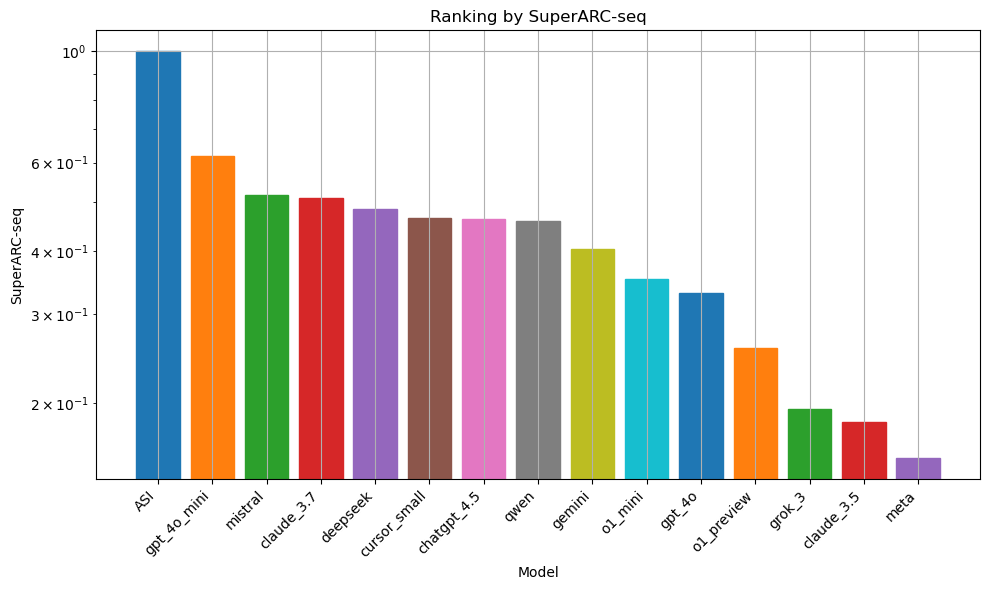

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Sort values in descending order
sorted_df = df_ranking2.sort_values('tst', ascending=False)
# Create bar plot using Model column with default color cycle
bars = plt.bar(range(len(sorted_df)), sorted_df['tst'])
# Set different colors for each bar using default color cycle
for i, bar in enumerate(bars):
    bar.set_color(f'C{i}')
plt.grid(True)
plt.title('Ranking by SuperARC-seq')
plt.xlabel('Model')
plt.ylabel('SuperARC-seq')
# Set y-axis to log scale
plt.yscale('log')
# Set x-tick labels with model names
plt.xticks(range(len(sorted_df)), sorted_df['Model'], rotation=45, ha='right')
plt.tight_layout()
plt.show()


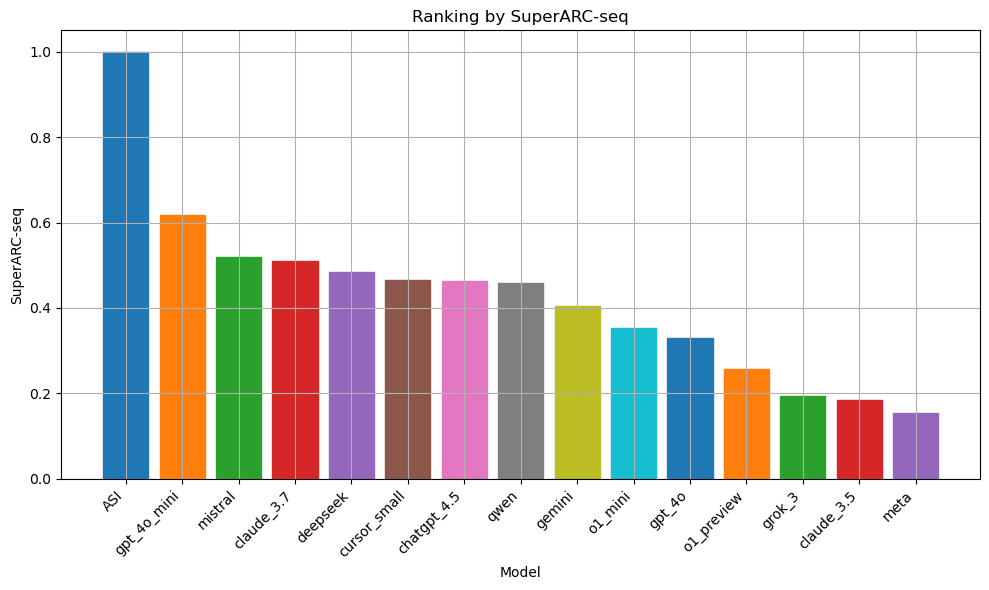

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Sort values in descending order
sorted_df = df_ranking2.sort_values('tst', ascending=False)
# Create bar plot using Model column with default color cycle
bars = plt.bar(range(len(sorted_df)), sorted_df['tst'])
# Set different colors for each bar using default color cycle
for i, bar in enumerate(bars):
    bar.set_color(f'C{i}')
plt.grid(True)
plt.title('Ranking by SuperARC-seq')
plt.xlabel('Model')
plt.ylabel('SuperARC-seq')

# Set x-tick labels with model names
plt.xticks(range(len(sorted_df)), sorted_df['Model'], rotation=45, ha='right')
plt.tight_layout()
# plt.savefig("rankingSuperARC.png", bbox_inches='tight',dpi=600)
plt.show()